In [39]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import json
import pickle
import numpy as np
import jionlp as jio
import numpy as np
import matplotlib.pyplot as plt

In [40]:
def load_data_json(json_path):
    f = open(json_path, 'r', encoding='utf-8')
    json_data = json.load(f)
    f.close()
    return json_data

In [41]:
json_path = f'./data/train_complete.json'
json_data = load_data_json(json_path)

# results_path = f'./output_results/train_result_colbert_text_keywords_hard_neg5_rand_neg30_epoch2'
# with open(results_path, 'rb') as handle:
#     results = pickle.load(handle)
# print(len(results))    
print(len(json_data))

559


In [42]:
data_mode = 'train'
binary_used_epoch = 2
# binary_results_paths = [
#     f'./output_results/{data_mode}_binary_result_cross_encoder_keywords_title_text_large_ensemble1_epoch{binary_used_epoch}',
#     f'./output_results/{data_mode}_binary_result_cross_encoder_keywords_title_text_large_ensemble2_epoch{binary_used_epoch}',
#     f'./output_results/{data_mode}_binary_result_cross_encoder_keywords_title_text_large_ensemble3_epoch{binary_used_epoch}',
#     f'./output_results/{data_mode}_binary_result_cross_encoder_keywords_title_text_large_ensemble4_epoch{binary_used_epoch}',
#     f'./output_results/{data_mode}_binary_result_cross_encoder_keywords_title_text_large_ensemble5_epoch{binary_used_epoch}',
# ]

binary_results_paths = [
#     'output_results/public_binary_result_cross_encoder_keywords_title_text_large_ensemble_alldata1',
#     'output_results/public_binary_result_cross_encoder_keywords_title_text_large_ensemble_alldata2',
#     'output_results/public_binary_result_cross_encoder_keywords_title_text_large_ensemble_alldata3',
#     'output_results/public_binary_result_cross_encoder_keywords_title_text_large_ensemble_alldata4',
#     'output_results/public_binary_result_cross_encoder_keywords_title_text_large_ensemble_alldata5',

#     'output_results/train_binary_result_cross_encoder_20_40_keywords_title_text_large_ensemble1',
#     'output_results/train_binary_result_cross_encoder_20_40_keywords_title_text_large_ensemble2',
#     'output_results/train_binary_result_cross_encoder_20_40_keywords_title_text_large_ensemble3',
# #     'output_results/train_binary_result_cross_encoder_20_40_keywords_title_text_large_ensemble4',
#     'output_results/train_binary_result_cross_encoder_20_40_keywords_title_text_large_ensemble5',
#     f'./output_results/val_test1',
#     f'./output_results/val_test2',
#     f'./output_results/val_test3',
    './output_results/train_binary_result_chinese-macbert-large_hard5_rand5_title_and_text_fixkeywords_ensemble1',
    './output_results/train_binary_result_chinese-macbert-large_hard5_rand5_title_and_text_fixkeywords_ensemble2',
    './output_results/train_binary_result_chinese-macbert-large_hard5_rand5_title_and_text_fixkeywords_ensemble3',


]
num_of_results = len(binary_results_paths)
print(num_of_results)

3


In [43]:
all_results = []

for binary_result_path in binary_results_paths:
# binary_result_path  = f'./output_results/public_binary_result_cross_encoder_keywords_title_text_large_ensemble1_epoch2'
    with open(binary_result_path, 'rb') as handle:
        binary_results = pickle.load(handle)
    print(len(binary_results))
    all_results.append(binary_results)


559
559
559


In [44]:
ensemble_results = {}
for did in all_results[0].keys():
    all_scores = []
    for binary_result in all_results:
        binary_scores = []
        ref_dids = []
        for ref_did, binary_score in binary_result[did]:
            binary_scores.append(binary_score)
            ref_dids.append(ref_did)
        all_scores.append(binary_scores)
    
#         print(all_scores)
#         input()

    all_scores = np.array(all_scores)
    all_scores = np.sum(all_scores, axis=0)
    all_scores = all_scores / num_of_results
    

    did_result = [(ref_did, score) for ref_did, score in zip(ref_dids, all_scores)]
    ensemble_results[did] = did_result

binary_results = ensemble_results
print(len(binary_results))

559


In [45]:
from sklearn.metrics import f1_score, recall_score, precision_score

from sklearn.preprocessing import MultiLabelBinarizer
multi = MultiLabelBinarizer()

all_dids = []
did2data = {}
for d in json_data:
    did = d['did']
    did2data[did] = d
    all_dids.append(did)


In [46]:
def jaccard_score(set1, set2):
    u = set1.union(set2) 
    i = set1.intersection(set2)
    if len(u) == 0:
        return 0
    return len(i) / len(u)


def dsc_score(set1, set2):
    i = set1.intersection(set2)
    if len(set1) + len(set2) == 0:
        return 0
    return (2 * len(i)) / (len(set1) + len(set2))

def overlap_coefficient(set1, set2):
    i = set1.intersection(set2)
    min_ = min(len(set1), len(set2))
    if min_ == 0:
        return 0
    return len(i) / min_


In [47]:
from collections import defaultdict
keyword_set_sim = defaultdict(dict)
for i in range(len(json_data)):
    for k in range(len(json_data)):
        
        did_i = json_data[i]['did']
        did_k = json_data[k]['did']
        
        set_i = set(json_data[i]['keyword_set'])
        set_k = set(json_data[k]['keyword_set'])
        
        sim_socre = dsc_score(set_i, set_k)
        keyword_set_sim[did_i][did_k] = sim_socre

#         inter = set_i.intersection(set_k)
#         keyword_set_sim[did_i][did_k] = len(inter)

In [48]:
for i in range(len(json_data)):
    did_i = json_data[i]['did']
    result = binary_results[did_i]
    
    
    set_sim_score = keyword_set_sim[did_i]
    for ref_did, score in set_sim_score.items():
        if did_i == ref_did:
            continue
        for k, r in enumerate(result):
            if r[0] == ref_did:
                r = r + (score,)
                result[k] = r
                break
    binary_results[did_i] = result

In [49]:
def get_static_info(li):
    mean = np.mean(li)
    median = np.median(li)
    std = np.std(li)
    max_ = np.max(li)
    min_ = np.min(li)
    print(f' mean {mean} median {median}, std {std}, max {max_}, min {min_}')
    
def show_pos_score(pos_dids, scores, all_ref_ids):
    for pos_did in pos_dids:
        pos_did_score = scores[np.where(all_ref_ids==pos_did)[0]]
        print(f'pos_did : {pos_did} softmax score: {pos_did_score}')


In [50]:
# binary_results = all_results[0]

binary_th = 0.4

for binary_th in np.arange(0.0, 1.0,0.1):
    print(f'binary_th = {binary_th}')
    all_pos_scores = []
    all_scores = []
    y = []
    y_binary = []

    
    for k, values in binary_results.items():
        did = str(k)

        binary_value = binary_results[k]

        data = did2data[did]
        pos_dids = data['pos_dids']
        if len(pos_dids) == 0:
            continue

        all_ref_ids = np.array([v[0] for v in values])


#         print(f'did = {k}')
#         print('label pos dids')
#         print(pos_dids)


        binary_scores = [v[1] for v in binary_value]
        binary_scores = np.array(binary_scores)
        binary_pos_idx = binary_scores >= binary_th
        binary_preds = all_ref_ids[binary_pos_idx]
        binary_pos_scores = binary_scores[binary_pos_idx]
#         print(binary_preds)


        set_scores =  [v[2] for v in values]
        set_scores = np.array(set_scores)
        set_pos_idx = set_scores >= 1
        set_preds = all_ref_ids[set_pos_idx]
        set_pred_scores = set_scores[set_pos_idx]
        
        mix_scores = 0.5 * binary_scores + 0.5 * set_scores
        mix_pos_idx = mix_scores >= binary_th
        mix_preds = all_ref_ids[mix_pos_idx]

        be_check_scores = mix_scores
        for pos_did in pos_dids :
            idx = np.where(all_ref_ids == pos_did)
            p_score = be_check_scores[idx][0]
    #         print(f'did : {all_ref_ids[idx]}, score : {p_score}')
            all_pos_scores.append(p_score)
        all_scores += list(be_check_scores)


        y.append(pos_dids)
        y_binary.append(mix_preds)


    multi = MultiLabelBinarizer()
    y_multi = multi.fit_transform(y)

    y_binary_multi = multi.transform(y_binary)
    average = 'macro'
    binary_f1  = f1_score(y_multi, y_binary_multi ,average=average)
    binary_recall  = recall_score(y_multi, y_binary_multi ,average=average)
    binary_precision  = precision_score(y_multi, y_binary_multi ,average=average)
#     print('binary')
    print(f'f1:{binary_f1}, recall:{binary_recall}, precision:{binary_precision} ')
#     break

binary_th = 0.0
f1:0.025949970508473676, recall:1.0, precision:0.013336877581662703 
binary_th = 0.1
f1:0.22280276835916982, recall:0.9913294797687862, precision:0.1428194804943829 
binary_th = 0.2
f1:0.41819319957492973, recall:0.9868421052631579, precision:0.32267891763738454 
binary_th = 0.30000000000000004
f1:0.5880144730658947, recall:0.9856628774582076, precision:0.487208700134104 
binary_th = 0.4
f1:0.7532110284842883, recall:0.9672176425389841, precision:0.6694669255598898 
binary_th = 0.5
f1:0.8700894904577382, recall:0.950773633753935, precision:0.8353720060638133 
binary_th = 0.6000000000000001
f1:0.8584816290113564, recall:0.8834116491568307, precision:0.8591494207462416 
binary_th = 0.7000000000000001
f1:0.7679229278313313, recall:0.7583597574144112, precision:0.8183888847183645 
binary_th = 0.8
f1:0.629034450737331, recall:0.5978521702616398, precision:0.7254335260115607 
binary_th = 0.9
f1:0.4308181915238383, recall:0.3903142932193425, precision:0.5558766859344894 


pos score
 mean 0.9063860499206877 median 0.9546301066875458, std 0.11310862460776505, max 0.9936179220676422, min 0.0716598853468895
1381


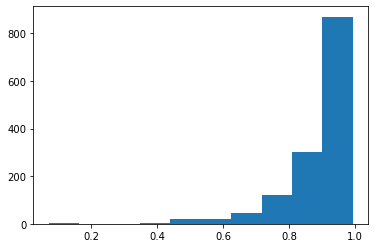

all score
 mean 0.062166299223841655 median 0.002556283725425601, std 0.13002708759591605, max 0.9936179220676422, min 0.0008548999321646988
167400


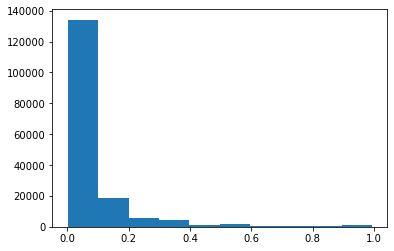

In [38]:
print('pos score')
get_static_info(all_pos_scores)
print(len(all_pos_scores))
n, bins, patches = plt.hist(all_pos_scores)
plt.show()

print('all score')
get_static_info(all_scores)
print(len(all_scores))

n, bins, patches = plt.hist(all_scores)
plt.show()

In [18]:
binary_th = 0.5

for binary_th in np.arange(0.9, 1,0.01):
    print(f'binary_th = {binary_th}')
    y = []
    y_binary = []
    for k, values in all_results[0].items():
        did = str(k)
        data = did2data[did]
        pos_dids = data['pos_dids']
        if len(pos_dids) == 0:
            continue

        all_ref_ids = np.array([v[0] for v in values])
        y.append(pos_dids)

        all_preds = []

        for single_binary_result in all_results:

            binary_value = single_binary_result[k]

            binary_scores = [v[1] for v in binary_value]
            binary_scores = np.array(binary_scores)
            binary_pos_idx = binary_scores >= binary_th
            binary_preds = all_ref_ids[binary_pos_idx]
            binary_pos_scores = binary_scores[binary_pos_idx]

            all_preds.append(set(binary_preds))

#         preds = set.intersection(*all_preds)
        preds = set.union(*all_preds)
        y_binary.append(list(preds))


    multi = MultiLabelBinarizer()
    y_multi = multi.fit_transform(y)

    y_binary_multi = multi.transform(y_binary)
    average = 'macro'
    binary_f1  = f1_score(y_multi, y_binary_multi ,average=average)
    binary_recall  = recall_score(y_multi, y_binary_multi ,average=average)
    binary_precision  = precision_score(y_multi, y_binary_multi ,average=average)
    #     print('binary')
    print(f'f1:{binary_f1}, recall:{binary_recall}, precision:{binary_precision} ')

binary_th = 0.9
f1:0.13007567971596748, recall:0.1275779376498801, precision:0.14285714285714285 
binary_th = 0.91
f1:0.12288143511165094, recall:0.12038369304556355, precision:0.13566289825282632 
binary_th = 0.92
f1:0.12209660842754368, recall:0.11918465227817746, precision:0.13566289825282632 
binary_th = 0.93
f1:0.12097750371131667, recall:0.11678657074340529, precision:0.13497773210003428 
binary_th = 0.9400000000000001
f1:0.120258079250885, recall:0.11438848920863308, precision:0.13477218225419665 
binary_th = 0.9500000000000001
f1:0.11210460203265958, recall:0.10599520383693045, precision:0.1275779376498801 
binary_th = 0.9600000000000001
f1:0.11165924403334475, recall:0.10479616306954437, precision:0.12829736211031173 
binary_th = 0.9700000000000001
f1:0.11014045906132237, recall:0.10119904076738609, precision:0.12949640287769784 
binary_th = 0.9800000000000001
f1:0.09821856800274066, recall:0.09112709832134293, precision:0.11630695443645082 
binary_th = 0.9900000000000001
f1:0

In [23]:
print('pos score')
get_static_info(all_pos_scores)
print(len(all_pos_scores))
n, bins, patches = plt.hist(all_pos_scores)
plt.show()

print('all score')
get_static_info(all_scores)
print(len(all_scores))

n, bins, patches = plt.hist(all_scores)
plt.show()

pos score
 mean [] median [], std [], max [0.98278946], min [0.98278946]
1692


/home/nlplab/harry/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/nlplab/harry/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 